In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from scripts.load_data import load_postings, load_votes, get_first_contact_df, subset_users

# reload imports jupyter magic
%load_ext autoreload
%autoreload 2

# Basic workflow of similarity computation


This notebook was used during development of the similarity computation. The code has been placed in to functions outside the notebook. We decided to keep it as it good documentation of the code and one can play around.

In [3]:
votes = load_votes("input/")
postings = load_postings("input/")
votes = votes.sort_values("VoteCreatedAt")
postings["num_interactions"] = postings.groupby("UserCommunityName")["PostingCreatedAt"].cumcount()

Votes loaded
Postings loaded


# Subsetting data

We don't want to have the following users
- users that interacted with only a few posts
- users that interacted with many posts, but in few days creating a skewed distribution

Therefore we set a threshold on the number of days a user has to interact minimum

Filtering users that interacted at the middle of the interval. Possible future extension: pick time interval instead of day

In [7]:
user_selection,_ = subset_users(votes, postings, "both", num_days_min=30, firt_interaction_middle=True)

/home/peter/anaconda3/envs/sna/lib/python3.10/site-packages/numpy/core/_methods.py:44: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/peter/anaconda3/envs/sna/lib/python3.10/site-packages/numpy/core/_methods.py:44: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/peter/anaconda3/envs/sna/lib/python3.10/site-packages/numpy/core/_methods.py:44: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library beha

In [10]:
user_selection.nunique() /  pd.concat([votes["UserCommunityName"], postings["UserCommunityName"]]).nunique()

0.04112515577710522

# Defining a notion of similarity

## 1. Comment article similarity
#### "Users are similar when they comments under the same articles (or articles of the same ressort)"

Todo: aggregate postings based on author and target (e.g., article, channel, ressort). Either count or just stay binary

In [11]:
selected_postings = postings[postings["UserCommunityName"].isin(user_selection)].sort_values("PostingCreatedAt")
selected_postings["UserCommunityName"] = "user_" + selected_postings["UserCommunityName"]


In [12]:
import itertools
# one can adapt this with e.g. ressort instead of article

def create_graph(df, article_or_ressort, user="UserCommunityName"):
    graph = nx.Graph()
    graph.add_nodes_from(df[article_or_ressort].unique())
    graph.add_nodes_from(df[user].unique())
    graph.add_edges_from(list(map(tuple, df[[article_or_ressort, user]].drop_duplicates().values)))
    graph = graph.to_undirected()
    return graph

def compute_overlap(graph, df, article_or_ressort,verbose=False):
    uu_overlap = {}
    article_ids = df[article_or_ressort].unique()
    for idx, article in enumerate(article_ids):
        if verbose: print(round((idx/len(article_ids))*100), "%", end="\r")
        users_commented =list(graph.neighbors(article))
        for uu_tuple in itertools.product(users_commented, users_commented):
            if uu_tuple[0] != uu_tuple[1]:
                if uu_tuple[0] > uu_tuple[1]:
                    uu_tuple = (uu_tuple[1], uu_tuple[0])
                if uu_tuple in uu_overlap:
                    uu_overlap[uu_tuple] += 1
                else:
                    uu_overlap[uu_tuple] = 1
                    
    return uu_overlap


In [13]:
def user_lookup_df(df, article_or_ressort):
    user_num_articles = df[["UserCommunityName", article_or_ressort]].drop_duplicates()\
        .groupby(["UserCommunityName"]).size().to_frame()
    # make dict of users and the number of articles they commented on
    user_num_articles = dict(zip(user_num_articles.index, user_num_articles[0]))
    return user_num_articles

Get the amount of common articles two users posted on

In [14]:
def compute_similarity(uu_overlap, user_num_articles, chunckIdx):
    similarities = []
    for uu_tuple in uu_overlap.keys():
        overlap = uu_overlap[uu_tuple]
        try:
            union = user_num_articles[uu_tuple[0]] + user_num_articles[uu_tuple[1]]
        except:
            print(uu_tuple)
        similarities += [[uu_tuple[0],uu_tuple[1], overlap / union]]
    return pd.DataFrame(similarities, columns=["A", "B", f"Similarity_{chunckIdx}"]).set_index(["A", "B"])


In [15]:
def compute_time_base_similiarities(selected_postings, article_or_ressort, num_chunks=30):
    sum_sims= 0
    n = 0
    chunks = []
    running_mean = []
    for chunckIdx, subset_df  in enumerate(np.array_split(selected_postings,num_chunks)):
        print(round(chunckIdx/num_chunks) *100, " %", end="\r")
        graph_ressort = create_graph(subset_df, article_or_ressort, "UserCommunityName")
        uu_overlap_ressort = compute_overlap(graph_ressort, subset_df, article_or_ressort)
        user_num_article_or_ressort = user_lookup_df(subset_df, article_or_ressort)
        similarity_table_ressort = compute_similarity(uu_overlap_ressort, user_num_article_or_ressort,chunckIdx)
        n += similarity_table_ressort.shape[0]
        sum_sims += similarity_table_ressort.sum().item()
        chunks += [similarity_table_ressort.mean()]
        running_mean += [sum_sims / n]
    return chunks, running_mean

In [16]:
time_similarity, time_similarity_running = compute_time_base_similiarities(selected_postings, "ID_Article")
#time_similarity_df = pd.concat(time_similarity_df[0:3], axis=1)
#time_similarity_df.to_csv("output/time_similarity_table_ressort.csv", index=False)

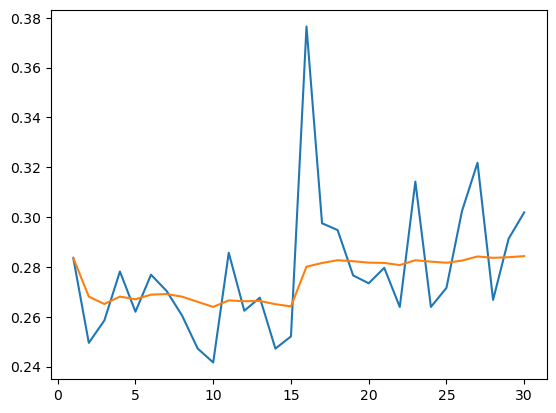

In [17]:
# import matplotlib 
from matplotlib import pyplot as plt
#time_similarity_df = pd.concat(time_similarity_running)
plt.plot(range(1,31), time_similarity)
plt.plot(range(1,31), time_similarity_running)